In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import tensorflow as tf
import os
from PIL import Image

dataset_path = '/content/drive/MyDrive/Machine learning lab/ML FINAL PROJECT/kagglecatsanddogs_5340/CATVSDOG'
img_size = (224, 224)
batch_size = 32
seed = 42

# Step 1: Clean the dataset (remove corrupted or empty files)
num_deleted = 0
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            if os.path.getsize(file_path) == 0:
                os.remove(file_path)
                num_deleted += 1
            else:
                with Image.open(file_path) as img:
                    img.verify()
        except Exception:
            os.remove(file_path)
            num_deleted += 1

print(f"Removed {num_deleted} corrupted or invalid files.")

# Step 2: Load the dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True
)

# Step 3: Split dataset (80% train, 20% test)
train_size = int(0.8 * len(full_ds))
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

# Step 4: Optional - Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Removed 1 corrupted or invalid files.
Found 2734 files belonging to 2 classes.


In [ ]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 2734 files belonging to 2 classes.


In [ ]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [ ]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

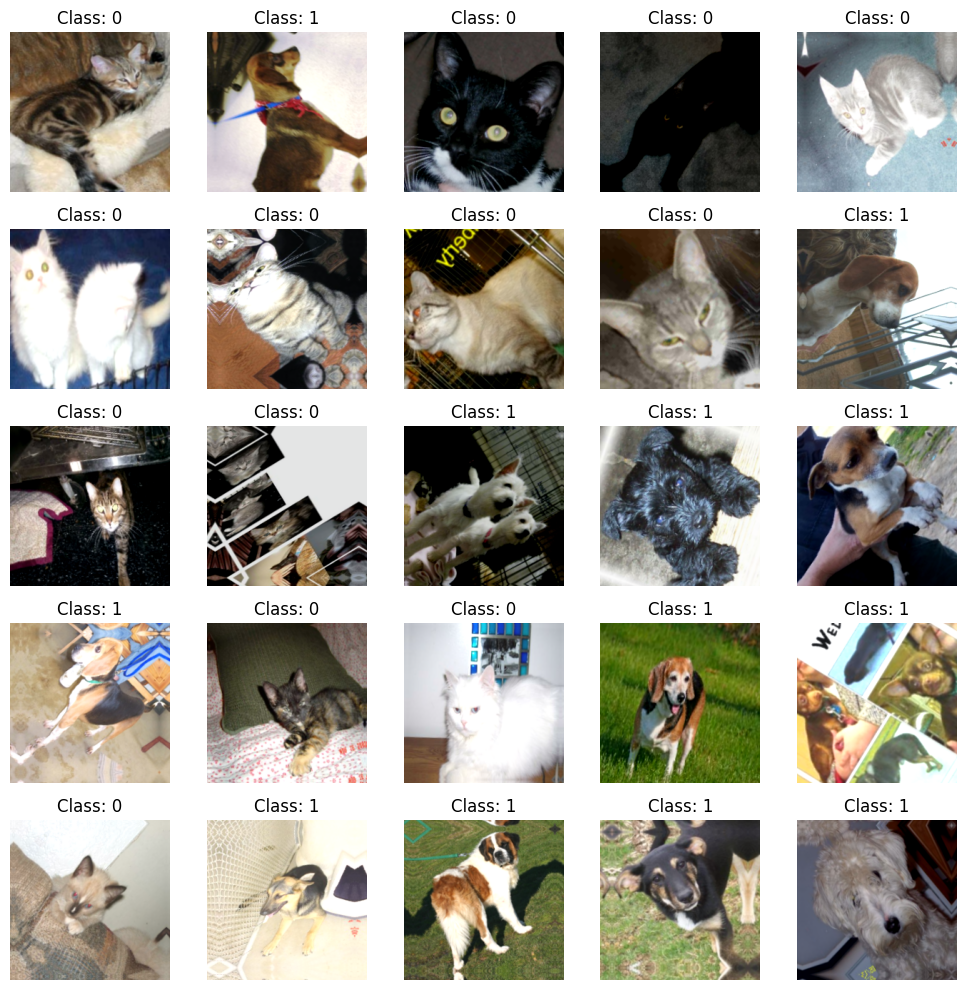

In [ ]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [ ]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,595,042 (21.34 MB)

 Trainable params: 5,595,042 (21.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Updated CNN Model Architecture

# Clear any previous TensorFlow session for a clean start
tf.keras.backend.clear_session()

model = Sequential([
    # Input layer
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),

    # Rescale pixel values
    Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'), # Increased filters, smaller kernel, added padding
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25), # Added Dropout

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Increased filters
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25), # Added Dropout

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Increased filters
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25), # Added Dropout

    # Flatten the output for dense layers
    Flatten(),

    # Dense layers
    Dense(512, activation='relu'), # Increased neurons
    Dropout(0.5), # Added Dropout
    Dense(256, activation='relu'),
    Dropout(0.5), # Added Dropout

    # Output layer
    Dense(len(full_ds.class_names), activation='softmax')
], name='improved_cnn_model') # Added a name for the model

## Compile the Updated Model

# Using Adam optimizer with a potentially lower learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Model Summary
model.summary()

Model: "improved_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,799,586 (197.60 MB)

 Trainable params: 51,799,586 (197.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 892s 13s/step - accuracy: 0.4899 - loss: 0.7407
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 909s 13s/step - accuracy: 0.5035 - loss: 0.6936
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 870s 13s/step - accuracy: 0.5082 - loss: 0.6932
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 913s 13s/step - accuracy: 0.4944 - loss: 0.6940
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 864s 13s/step - accuracy: 0.5006 - loss: 0.6936
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 866s 13s/step - accuracy: 0.5203 - loss: 0.6930
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 930s 13s/step - accuracy: 0.5020 - loss: 0.6933
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 876s 13s/step - accuracy: 0.4957 - loss: 0.6939
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 881s 13s/step - accuracy: 0.5075 - loss: 0.6934
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 876s 13s/step - accuracy: 0.5084 - loss: 0.6931


In [ ]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.4859 - loss: 0.6936
Test Accuracy: 0.51


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1422s 21s/step - accuracy: 0.6607 - loss: 18.1006
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1413s 21s/step - accuracy: 0.8903 - loss: 0.2468
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1420s 21s/step - accuracy: 0.9052 - loss: 0.2055
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1453s 21s/step - accuracy: 0.9279 - loss: 0.1881
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1451s 21s/step - accuracy: 0.9302 - loss: 0.1565
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1407s 21s/step - accuracy: 0.9390 - loss: 0.1524
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1459s 21s/step - accuracy: 0.9444 - loss: 0.1359
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1398s 21s/step - accuracy: 0.9379 - loss: 0.1501
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1393s 20s/step - accuracy: 0.9531 - loss: 0.1306
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1395s 20s/step - accuracy: 0.9541 - loss: 0.1202
18/18 ━━━━━━━━━━━━━━━━━━━━ 354s 19s/step - accuracy: 0.9596 - loss: 0.0925
Test Accuracy: 0.97


KeyError: 'val_accuracy'

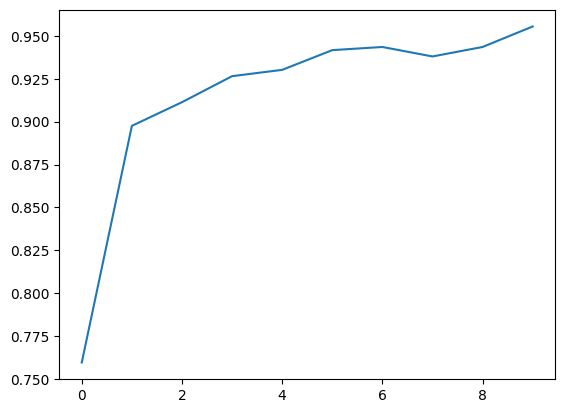

In [17]:
# Transfer Learning

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


In [19]:
# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 373s 20s/step - accuracy: 0.9745 - loss: 0.0930
Validation Accuracy: 97.31%
